<a href="https://colab.research.google.com/github/raulbenitez/IWANN21/blob/main/deep_MNIST_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
folder_data = '/content/drive/MyDrive/IWANN_course_data'
load_data = 'True' #Set to 'True' to load data and avoid time consuming executions

# MNIST data exploration

## Load MNIST data

In [132]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Load data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Visualize image dataset 

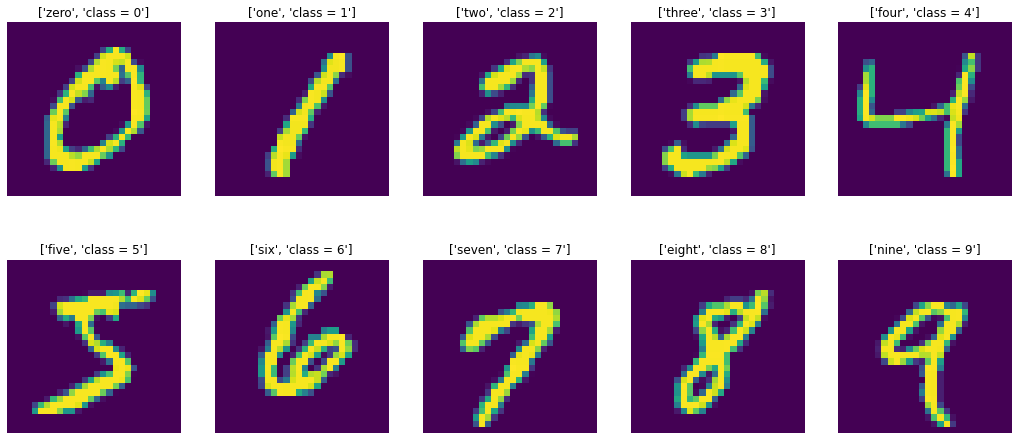

In [3]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pylab as plt

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

fig = plt.figure(figsize=(18, 8))

for kclass in range(0,10):
    ind = np.argwhere(y_train==kclass)
    ax = fig.add_subplot(2, 5, kclass+1)
    ax.imshow(x_train[ind[0][0]].squeeze())
    ax.set_title([label_names[kclass], 'class = {}'.format(kclass)])
    ax.axis('off')

## Low-dimension projections of the MNIST test data subset

## 2D PCA projection

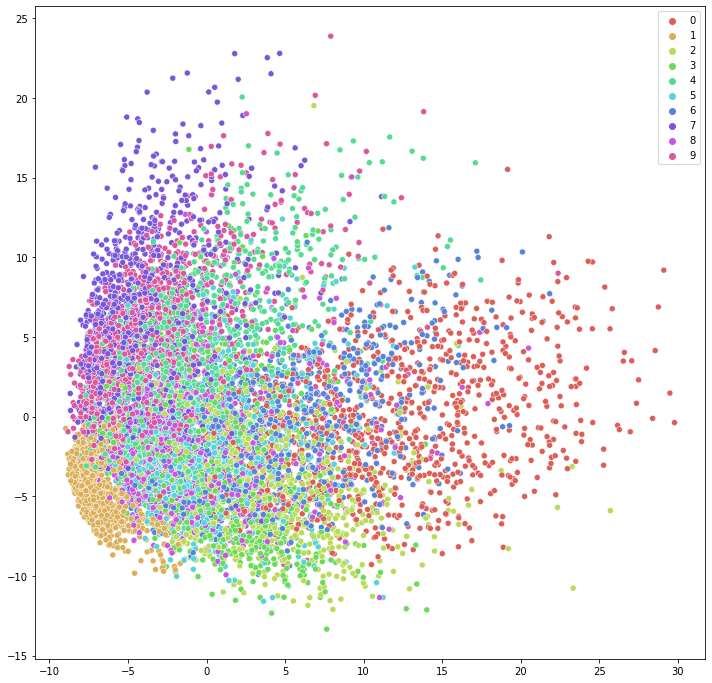

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Reshape as NOBSERVATIONS x NPIXELS:
train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

# Scale (Standardization)
train = StandardScaler().fit_transform(train)
test = StandardScaler().fit_transform(test)

# PROJECT TO A 2D PCA SPACE:
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = pca_proj[:,0], y = pca_proj[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full')

In [5]:
print('The size of flattened training data is {}'.format(train.shape))
print('The size of flattened test data is {}'.format(test.shape))

The size of flattened training data is (60000, 784)
The size of flattened test data is (10000, 784)


No surprise that all classes are entangled in the 2d PCA projection since the variance explained by a 2D PCA projection is only a fraction of the total variability:

In [6]:
pca.explained_variance_ratio_.cumsum()

array([0.06196849, 0.10440609], dtype=float32)

## T-SNE projection 

(CPU time = 4.24 min , 3.51 min with GPU)

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf



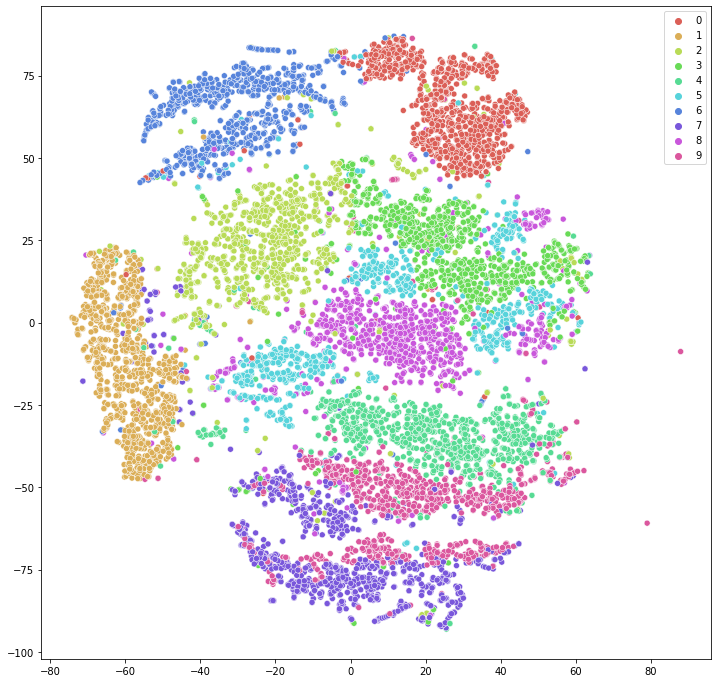

In [7]:
from sklearn.manifold import TSNE

if load_data == 'False':
  tsne = TSNE(n_components = 2, random_state=0)
  tsne_res = tsne.fit_transform(test)
else:
  data = np.load(folder_data+'/tsne.npz')
  tsne_res = data['arr_1']

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

## PCA + t-SNE

Let's first project into a PCA space explaining 95% of the variability and then visualize the PCA projection using a 2D t-SNE manifold

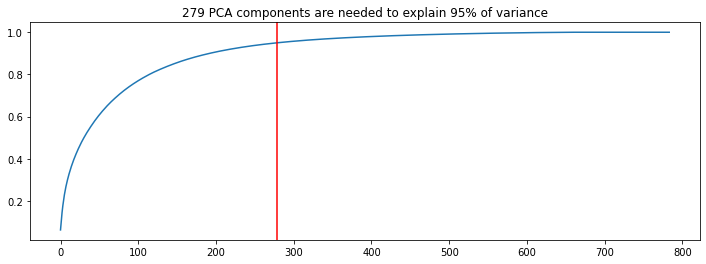

In [8]:
pca_full = PCA(n_components=test.shape[1])
pca_full.fit(test)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(12,4))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

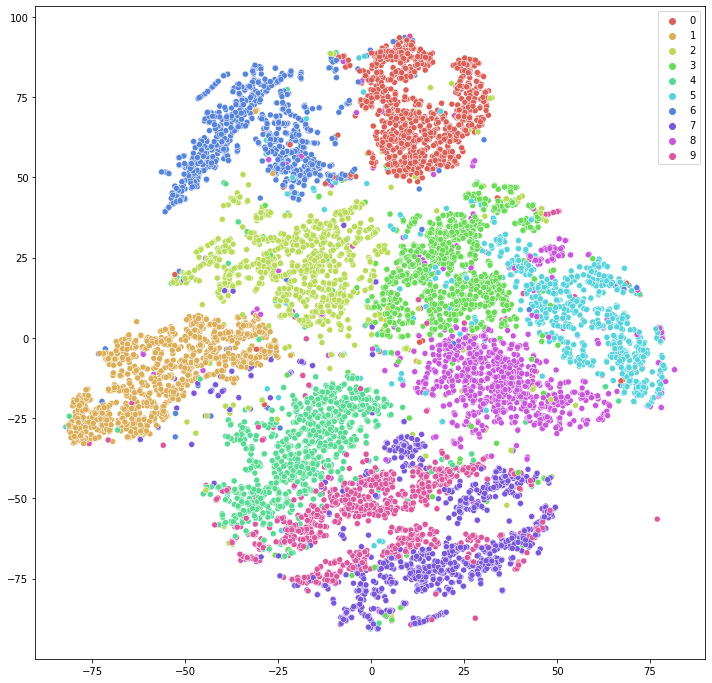

In [9]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(test)

if load_data == 'False':
  tsne = TSNE(n_components = 2, random_state=0)
  tsne_pca = tsne.fit_transform(pca95_proj)
  np.savez(folder_data+'/tsne.npz', tsne_pca,tsne_res)
else:
  data = np.load(folder_data+'/tsne.npz')
  tsne_pca = data['arr_0']

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

PCA as feature extraction works pretty well (eigenfaces)

## Clustering - unsupervised approach
In this section we apply an unsupervised clustering approach to identfy each cluster in the feature space. In particular, we apply a Gaussian Mixture Model with model selection using the Bayesian Information Criterion parsimony index.


[203909.00391066918]
[203909.00391066918, 202154.94855921602]
[203909.00391066918, 202154.94855921602, 201105.4537294496]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814, 199100.27451060523]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814, 199100.27451060523, 198421.62656347183]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814, 199100.27451060523, 198421.62656347183, 198201.20965661437]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814, 199100.27451060523, 198421.62656347183, 198201.20965661437, 197958.57615950008]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814, 199100.27451060523, 198421.62656347183, 198201.20965661437, 197958.57615950008, 197998.60511034657]
[203909.00391066918, 202154.94855921602, 201105.4537294496, 199392.1608187814, 199100.27451060523, 19842

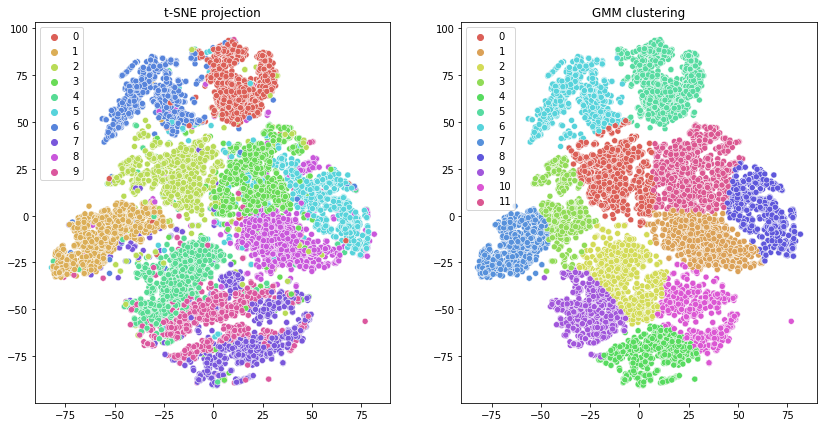

In [10]:
from sklearn import mixture

X = tsne_pca[:,0:2]

NMAX = 12
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(X)
    bic.append(gmm.bic(X))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(X)
y_pred_gmm = gmm.fit_predict(X)


plt.figure(figsize=(14,7))

ax0 = plt.subplot(1,2,1)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');
plt.title("t-SNE projection")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_pred_gmm, palette = sns.hls_palette(idx_winner+1));
plt.title("GMM clustering")
plt.show()

Some digits can be easily identified as an isolated cluster, others are identified as two subgroups. We also observe that two different digits are grouped together as a single cluster. 

## UMAP Projection

https://arxiv.org/abs/1802.03426

https://umap-learn.readthedocs.io/en/latest/

First, install UMAP library in google colab platform

In [11]:
!pip install umap-learn

In [12]:
import umap

if load_data == 'False':
  embedding = umap.UMAP(n_neighbors=5).fit_transform(test)
  np.savez(folder_data+'/umap.npz', embedding)
else: 
  data = np.load(folder_data+'/umap.npz')
  embedding = data['arr_0']

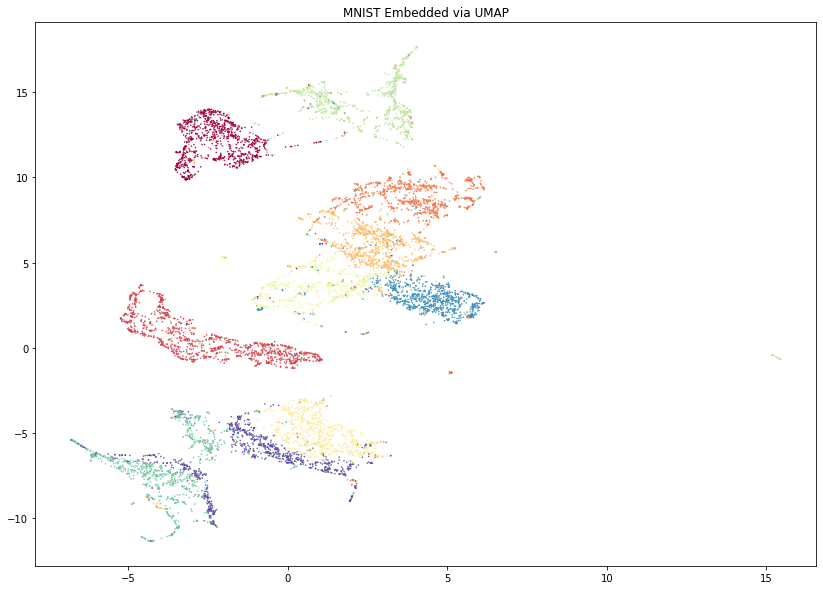

In [13]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=y_test, cmap='Spectral', alpha=1.0)
plt.title('MNIST Embedded via UMAP');

Let's try now the clustering 

[117883.00078431713]
[117883.00078431713, 114964.94461159474]
[117883.00078431713, 114964.94461159474, 111945.15366539825]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232, 106982.31751460081]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232, 106982.31751460081, 105638.40189333279]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232, 106982.31751460081, 105638.40189333279, 104869.20899624864]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232, 106982.31751460081, 105638.40189333279, 104869.20899624864, 104320.42882669956]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232, 106982.31751460081, 105638.40189333279, 104869.20899624864, 104320.42882669956, 104097.0922962042]
[117883.00078431713, 114964.94461159474, 111945.15366539825, 109143.04041819232, 106982.3175

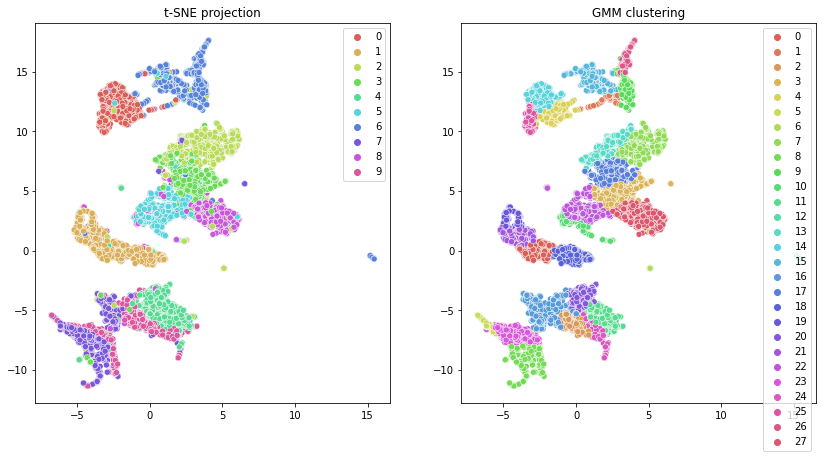

In [14]:
from sklearn import mixture

X = embedding

NMAX =30
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(X)
    bic.append(gmm.bic(X))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(X)
y_pred_gmm = gmm.fit_predict(X)


plt.figure(figsize=(14,7))

ax0 = plt.subplot(1,2,1)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');
plt.title("t-SNE projection")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_pred_gmm, palette = sns.hls_palette(idx_winner+1));
plt.title("GMM clustering")
plt.show()

Similar problems are observed when using the UMAP embedding 

# The Traditional Machine Learning approach: eigenfaces

Use PCA to extract features from the images and classify them using a KNN  algorithm.

PCA to explain 95% of the variance in the training set.

In [15]:
# GET PCA FEATURES PROJECTING TO THE PCA SPACE:
pca_train = pca95.fit_transform(train)
pca_test = pca95.fit_transform(test)

print('Number of PCA components needed to explain 95% of variability is {}'.format(Ncomponents_95))
print('The PCA training set has dimensions {} {}'.format(*pca_train.shape))
print('The PCA test set has dimensions {} {}'.format(*pca_test.shape))

Number of PCA components needed to explain 95% of variability is 279
The PCA training set has dimensions 60000 279
The PCA test set has dimensions 10000 279


## Fit a kNN classifier using PCA features
(CPU time 8:54 min)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
import pickle 

if load_data == 'False':
  knn = KNeighborsClassifier(n_neighbors=2) # load the model
  knn.fit(pca_train,y_train) # fit the model using training data
  y_test_pred = knn.predict(pca_test) # model prediction of test data

  pickle.dump(knn, open(folder_data+'/knn_pca_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred.npz', y_test_pred)

else:
  knn = pickle.load(open(folder_data+'/knn_pca_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred.npz')
  y_test_pred = data['arr_0']


Text(0.5, 1.0, 'KNN pca features classification')

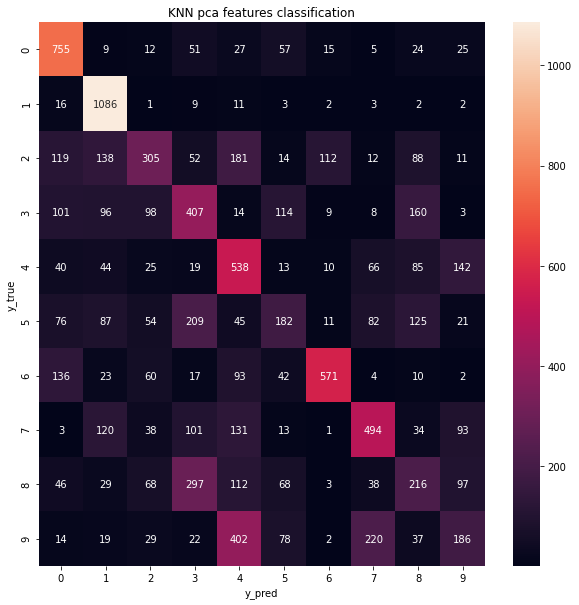

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN pca features classification')

In [18]:
from sklearn.metrics import classification_report

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.58      0.77      0.66       980
         one       0.66      0.96      0.78      1135
         two       0.44      0.30      0.35      1032
       three       0.34      0.40      0.37      1010
        four       0.35      0.55      0.42       982
        five       0.31      0.20      0.25       892
         six       0.78      0.60      0.67       958
       seven       0.53      0.48      0.50      1028
       eight       0.28      0.22      0.25       974
        nine       0.32      0.18      0.23      1009

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.45     10000
weighted avg       0.46      0.47      0.45     10000



Traditional features do not always represent the full complexity of the classification problema

## Fit a KNN classifier using raw data

In [30]:
load_data='True'

              precision    recall  f1-score   support

        zero       0.92      0.99      0.95       980
         one       0.94      1.00      0.97      1135
         two       0.93      0.94      0.93      1032
       three       0.90      0.95      0.92      1010
        four       0.92      0.96      0.94       982
        five       0.91      0.90      0.91       892
         six       0.98      0.94      0.96       958
       seven       0.91      0.93      0.92      1028
       eight       0.98      0.85      0.91       974
        nine       0.97      0.86      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



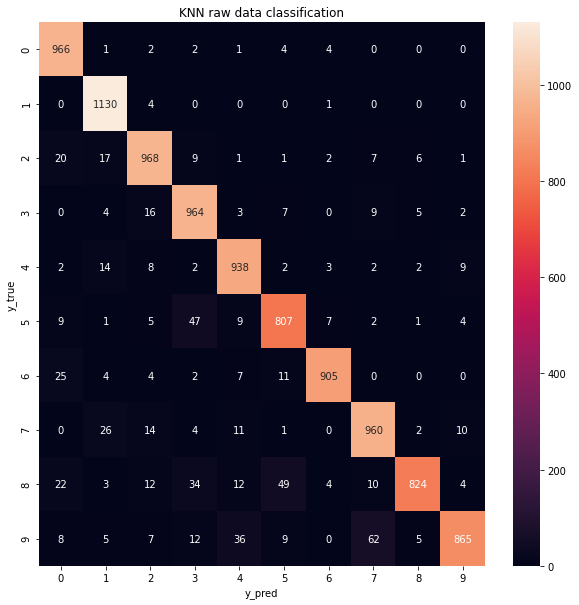

In [31]:
from sklearn.neighbors import KNeighborsClassifier

if load_data == 'False':
  knn_raw = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_raw.fit(train,y_train) # fit the model using training data
  y_test_pred_raw = knn_raw.predict(test) # model prediction of test data

  pickle.dump(knn_raw, open(folder_data+'/knn_raw_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_raw.npz', y_test_pred_raw)

else:
  knn_raw = pickle.load(open(folder_data+'/knn_raw_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_raw.npz')
  y_test_pred_raw = data['arr_0']

cm_raw = confusion_matrix(y_test, y_test_pred_raw)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_raw,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN raw data classification')

print(classification_report(y_test, y_test_pred_raw, target_names=label_names))

# Classification using Deep Features

Use a pre-trained CNN architecture to extract deep features

## Pre-processing data 

Some pre-processing is needed in order to adjust input data to the CNN architecture

Convert training and test subsets in 3-channel images

In [32]:
x_train3 = np.dstack([train] * 3)
x_test3 = np.dstack([test]*3)
x_train3.shape,x_test3.shape

((60000, 784, 3), (10000, 784, 3))

Reshape images images in tensor format required by tensorflow

In [33]:
# Reshape images as per the tensor format required by tensorflow
train_X = x_train3.reshape(-1, 28,28,3)
test_X = x_test3.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Resize the images 48*48 as required by VGG16 architecture

In [34]:
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

Normalise the data and change data type to float


In [35]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

Preprocess the input 


In [36]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_X = preprocess_input(train_X)
test_X  = preprocess_input(test_X)

Instantiate the VGG16 model pre-trained with imagenet database. We load only the layers corresponding to the feature extraction and skip the last fully connected layers for classification (include_top=False). 


In [37]:
from tensorflow.keras.applications.vgg16 import VGG16

# Parameters:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

# model:
model = VGG16(weights='imagenet',include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

## Extract deep features:

In [42]:
# Extracting features
if load_data == 'False':
  train_deep_features = model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
  test_deep_features = model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
  
  np.savez(folder_data+'/deep_feat.npz', train_deep_features, train_X,test_deep_features, test_X)
else: 
  data = np.load(folder_data+'/deep_feat.npz')
  train_deep_features = data['arr_0']
  train_X = data['arr_1']
  test_deep_features = data['arr_2']
  test_X = data['arr_3']

train_deep_features.shape,test_deep_features.shape

((60000, 1, 1, 512), (10000, 1, 1, 512))

## visualize using UMAP

In [114]:
if load_data == 'False':
  umap_deep = umap.UMAP(n_neighbors=5).fit_transform(test_deep_features.squeeze())
  np.savez(folder_data+'/umap_deep.npz', umap_deep)
else: 
  data = np.load(folder_data+'/umap_deep.npz')
  umap_deep = data['arr_0']

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_deep[:,0], y = umap_deep[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

## Visualize deep features using t-SNE

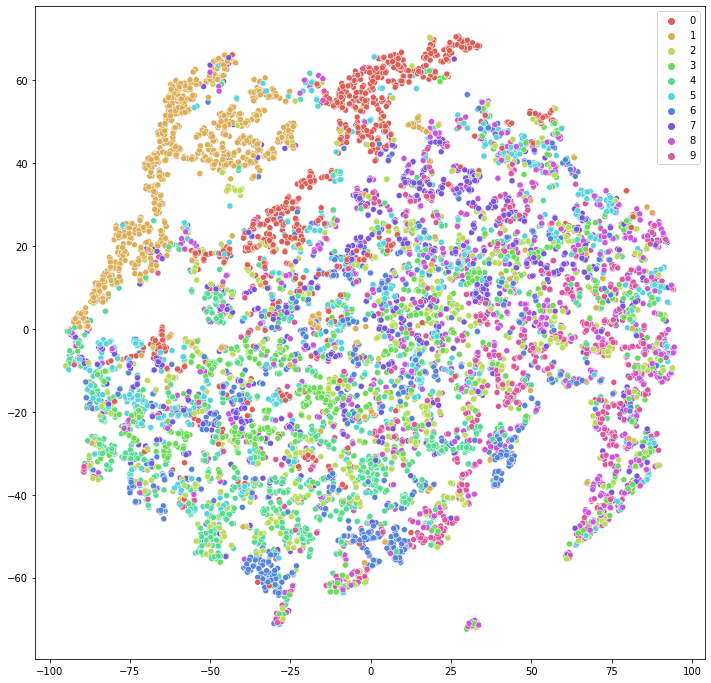

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0)
tsne_deep = tsne.fit_transform(test_deep_features.squeeze())

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_deep[:,0], y = tsne_deep[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

## Classify with deep features

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=2) # load the model
knn.fit(train_deep_features.squeeze(),y_train) # fit the model using training data 
y_test_pred = knn.predict(test_deep_features.squeeze()) # model prediction of test data

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.66      0.86      0.75       980
         one       0.71      0.96      0.82      1135
         two       0.38      0.49      0.43      1032
       three       0.45      0.49      0.47      1010
        four       0.60      0.70      0.64       982
        five       0.43      0.43      0.43       892
         six       0.65      0.52      0.57       958
       seven       0.58      0.61      0.60      1028
       eight       0.54      0.23      0.32       974
        nine       0.77      0.36      0.49      1009

    accuracy                           0.57     10000
   macro avg       0.58      0.56      0.55     10000
weighted avg       0.58      0.57      0.56     10000



We see that the overall accuracy of the classifier improves when using deep features instead PCA features

# The full DL approach

Both feature extraction and classification are performed using a simple custom-made CNN architecture. 
MNIST classification using a simple CNN architecture - Saving the weights

From 
https://keras.io/examples/vision/mnist_convnet/
https://www.tensorflow.org/guide/keras/save_and_serialize

### Build and train

In [67]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [133]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)


# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [134]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
features (Flatten)           (None, 1600)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)              

In [135]:
batch_size =256
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
211/211 [==============================] - 2s 8ms/step - loss: 0.5109 - accuracy: 0.8499 - val_loss: 0.1046 - val_accuracy: 0.9710
Epoch 2/5
211/211 [==============================] - 1s 7ms/step - loss: 0.1344 - accuracy: 0.9598 - val_loss: 0.0667 - val_accuracy: 0.9827
Epoch 3/5
211/211 [==============================] - 1s 7ms/step - loss: 0.0969 - accuracy: 0.9700 - val_loss: 0.0560 - val_accuracy: 0.9848
Epoch 4/5
211/211 [==============================] - 1s 7ms/step - loss: 0.0823 - accuracy: 0.9744 - val_loss: 0.0482 - val_accuracy: 0.9867
Epoch 5/5
211/211 [==============================] - 1s 7ms/step - loss: 0.0710 - accuracy: 0.9784 - val_loss: 0.0448 - val_accuracy: 0.9868


### Save trained weights

In [136]:
model.save(folder_data + '/model_saved')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IWANN_course_data/model_saved/assets


### Evaluate 

In [137]:
score = model1.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04152213782072067
Test accuracy: 0.9871000051498413


## Use the trained model for Feature Extraction

In [138]:
from tensorflow.keras.models import Model

base_model = keras.models.load_model(folder_data + '/model_saved')

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('features').output)
model_FE.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
features (Flatten)           (None, 1600)              0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_______________________________________________________

In [145]:
df_test = model_FE.predict(x_test)

In [146]:
if load_data == 'False':
  umap_df = umap.UMAP(n_neighbors=5).fit_transform(df_test.squeeze())
  np.savez(folder_data+'/umap_df.npz', umap_df)
else: 
  data = np.load(folder_data+'/umap_df.npz')
  umap_df= data['arr_0']


In [147]:
umap_df.shape

(10000, 2)

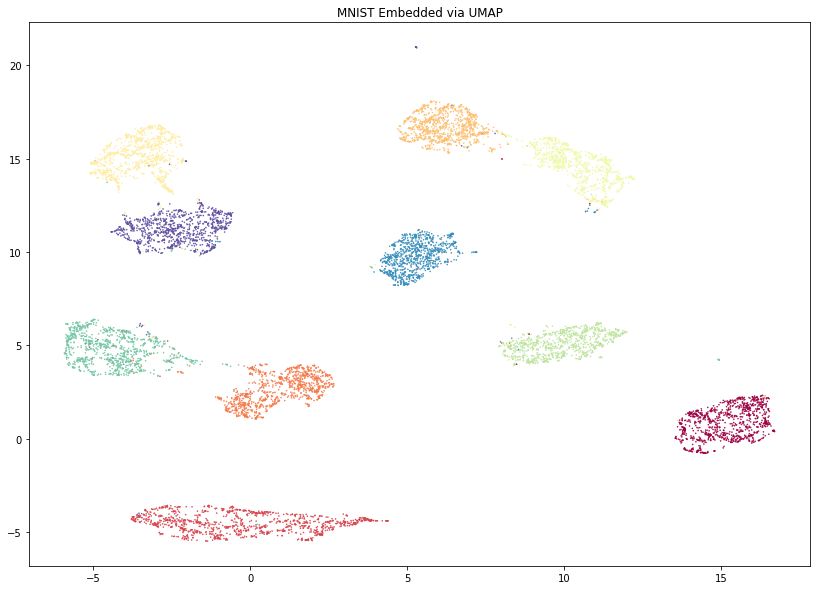

In [148]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*umap_df.T, s=0.3, c=y_test, cmap='Spectral', alpha=1.0)
plt.title('MNIST Embedded via UMAP');

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pickle 

# extract features from the training subset:
df_train = model_FE.predict(x_train)

if load_data == 'False':
  knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_DL.fit(df_train,y_train) # fit the model using training data
  y_test_pred_DL = knn_DL.predict(df_test) # model prediction of test data

  pickle.dump(knn_DL, open(folder_data+'/knn_DL_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_DL.npz', y_test_pred_DL)

else:
  knn_DL = pickle.load(open(folder_data+'/knn_DL_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_DL.npz')
  y_test_pred_DL = data['arr_0']